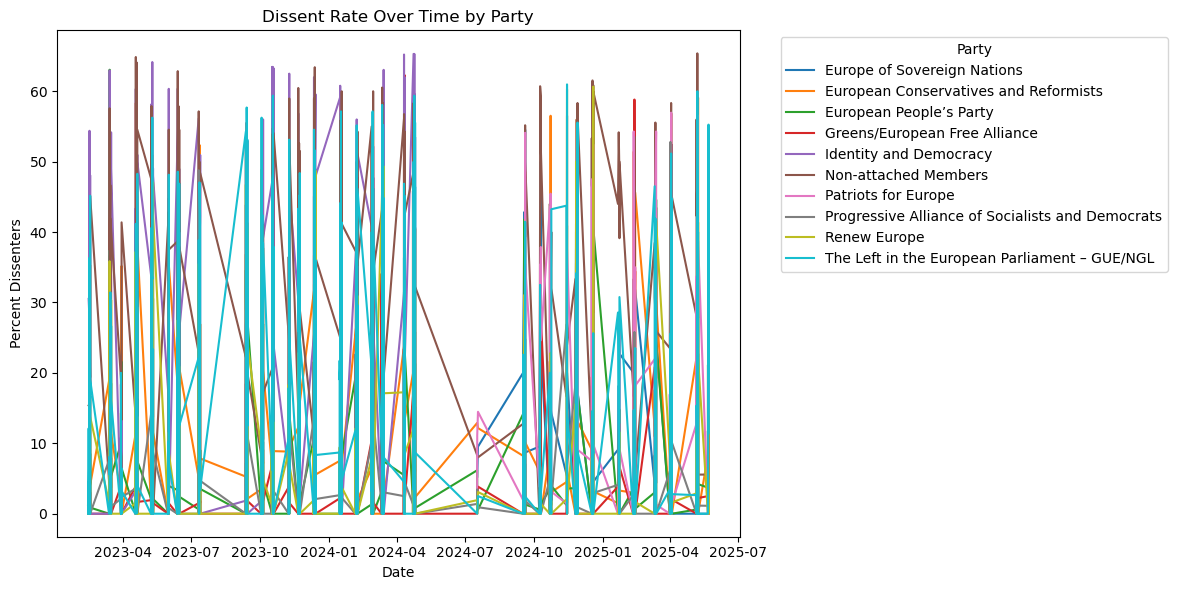

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# read in csv, convert date column to date times
df = pd.read_csv('processed_votes_updated.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# fix total votes and dissent percent to exclude no votes
df['total_votes'] = df[['votes_for', 'votes_against', 'abstentions']].sum(axis=1)
df['majority_col'] = df[['votes_for', 'votes_against', 'abstentions', 'no_votes']].idxmax(axis=1)
df['percent_dissenters'] = ((df['total_votes'] - df['majority_vote_count']) / df['total_votes']) * 100
# drop rows where no votes is the majority
df = df[df['majority_col'] != 'no_votes']

# sort values in order by date
df = df.sort_values('date')

# save to csv
df.to_csv('exclude_no_votes.csv', index=False)

# plot a line for each party of date vs percent dissenters
plt.figure(figsize=(12, 6))

for party, group in df.groupby('party'):
    plt.plot(group['date'], group['percent_dissenters'], label=party)

# add labels, legend, title
plt.xlabel('Date')
plt.ylabel('Percent Dissenters')
plt.title('Dissent Rate Over Time by Party')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


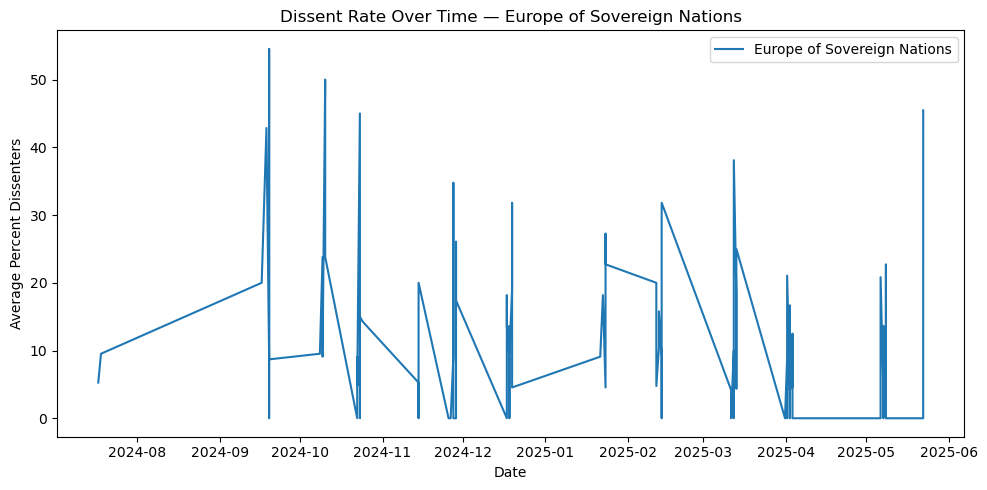

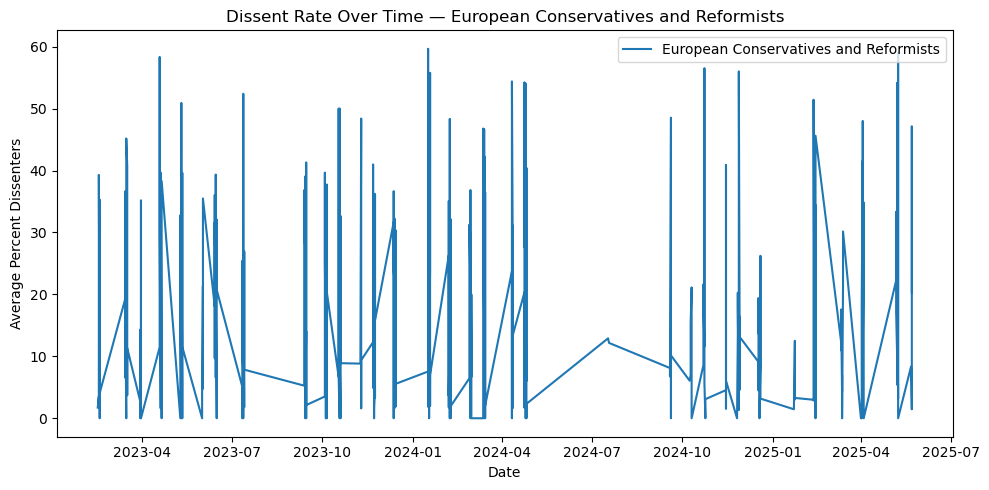

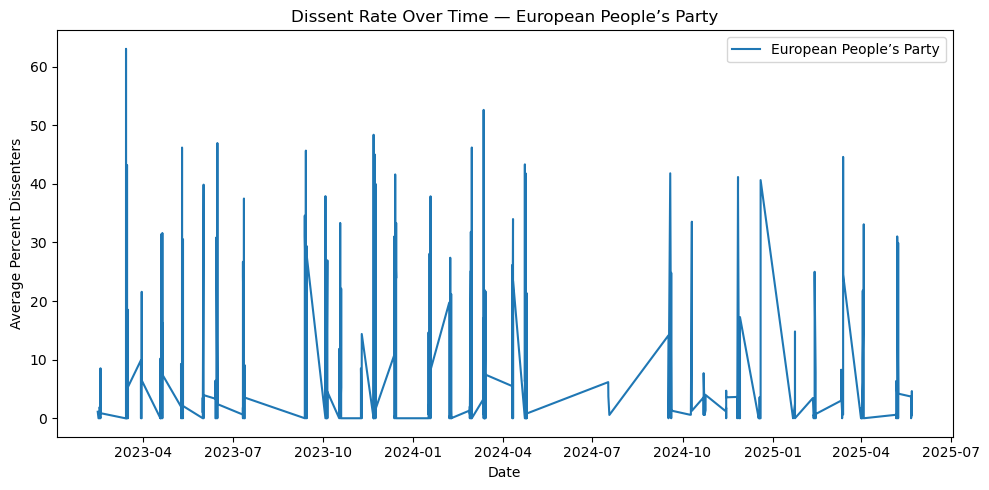

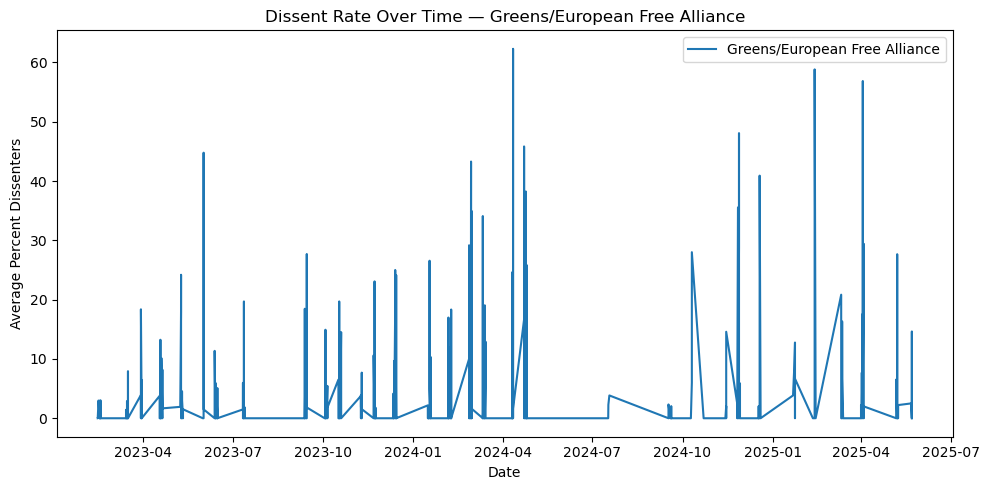

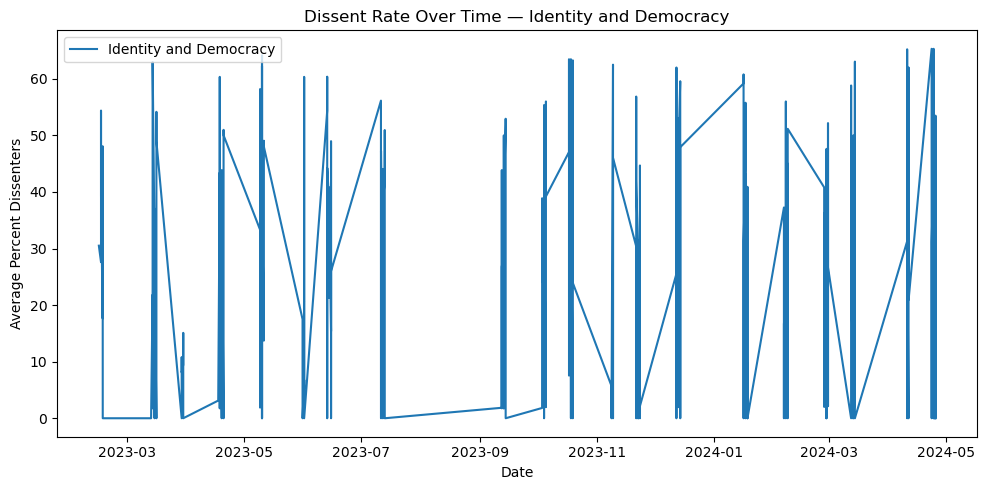

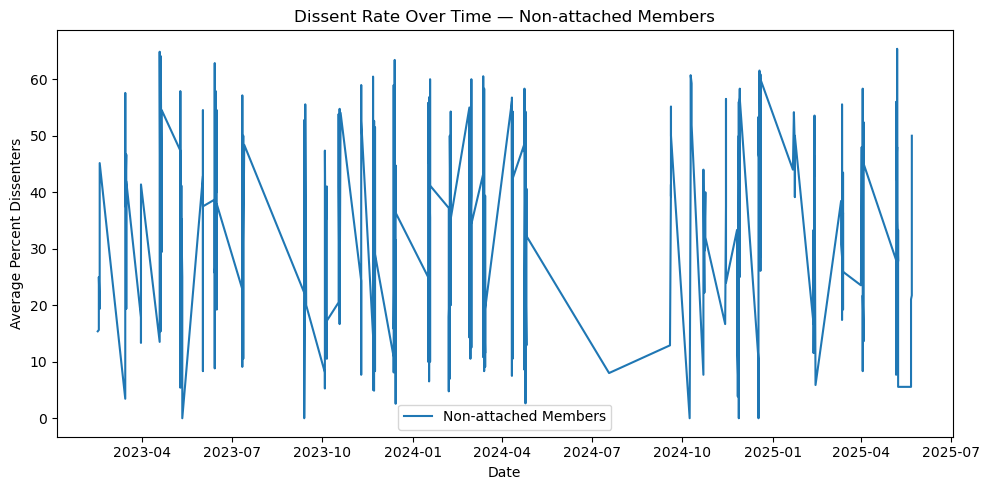

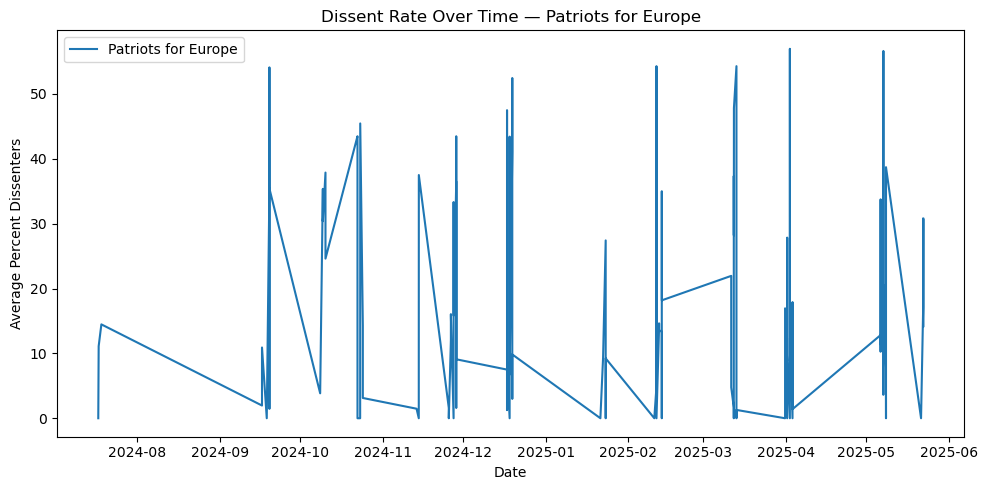

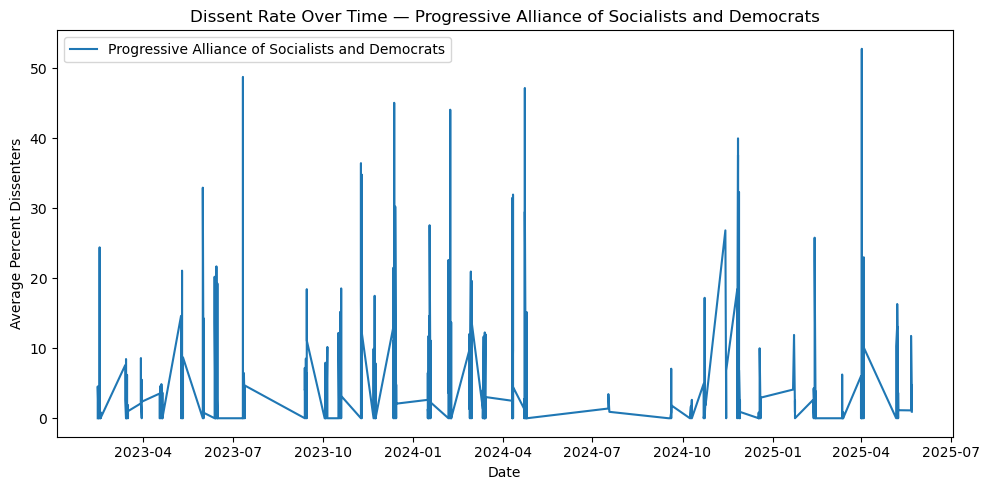

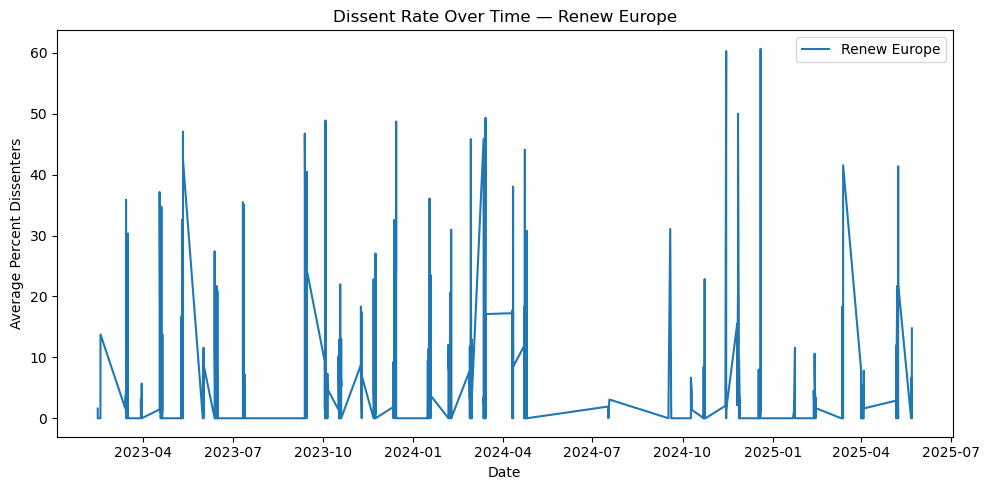

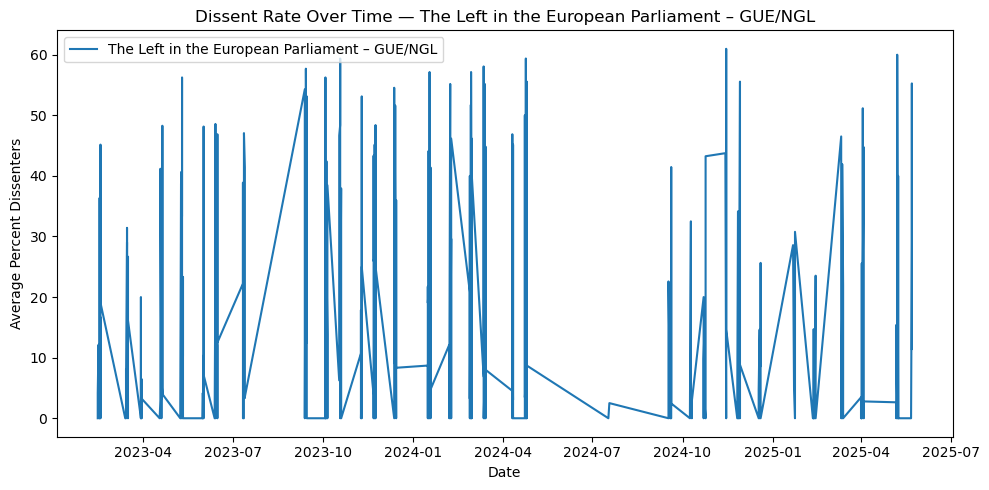

In [ ]:
# group by party and date, average same-day votes
df_grouped = df.groupby(['party', 'date'])['percent_dissenters'].mean().reset_index()
df_grouped = df_grouped.sort_values('date')

# plot a separate figure for each party
for party, group in df_grouped.groupby('party'):
    plt.figure(figsize=(10, 5))
    plt.plot(group['date'], group['percent_dissenters'], label=party)

    plt.xlabel('Date')
    plt.ylabel('Average Percent Dissenters')
    plt.title(f'Dissent Rate Over Time — {party}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
from sklearn.linear_model import LinearRegression

# store per-party stats
party_trends = []

for party, group in df.groupby('party'):
    group = group.dropna(subset=['percent_dissenters', 'date'])
    if len(group) < 10:
        continue
    
    group['date_ordinal'] = group['date'].map(pd.Timestamp.toordinal)
    X = group['date_ordinal'].values.reshape(-1, 1)
    y = group['percent_dissenters'].values
    
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    r_squared = model.score(X, y)
    
    party_trends.append({
        'party': party,
        'slope': slope,
        'r_squared': r_squared
    })

# create DataFrame
trend_df = pd.DataFrame(party_trends)

# sort and analyze stats
print("Top Increasing Dissent Trends:")
print(trend_df.sort_values('slope', ascending=False).head())

print("\nTop Decreasing Dissent Trends:")
print(trend_df.sort_values('slope').head())

Top Increasing Dissent Trends:
                                              party     slope  r_squared
5                              Non-attached Members  0.006112   0.007173
3                     Greens/European Free Alliance  0.006094   0.028247
7  Progressive Alliance of Socialists and Democrats  0.002164   0.004512
2                           European People’s Party  0.001852   0.001565
8                                      Renew Europe  0.000392   0.000083

Top Decreasing Dissent Trends:
                                           party     slope  r_squared
0                    Europe of Sovereign Nations -0.034117   0.059337
6                            Patriots for Europe -0.012840   0.004668
9  The Left in the European Parliament – GUE/NGL -0.003564   0.002304
4                         Identity and Democracy -0.001443   0.000106
1          European Conservatives and Reformists -0.001228   0.000387


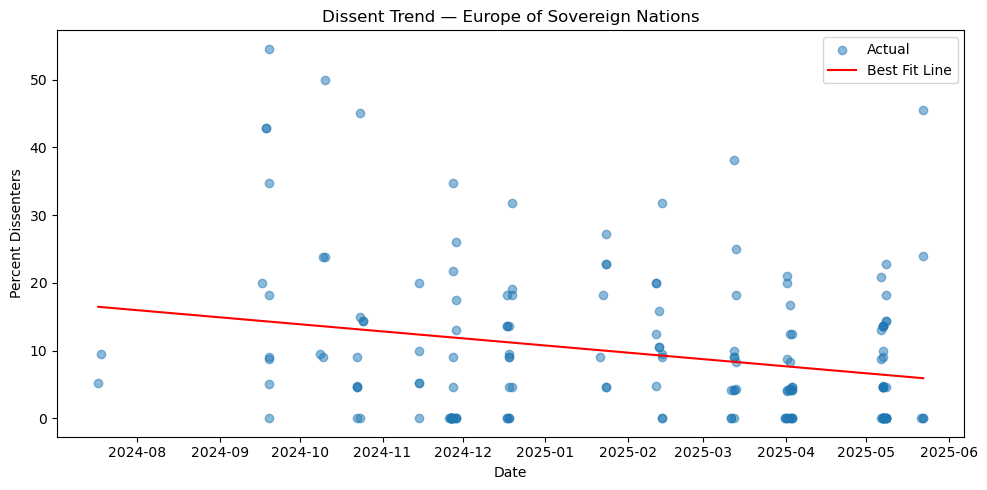

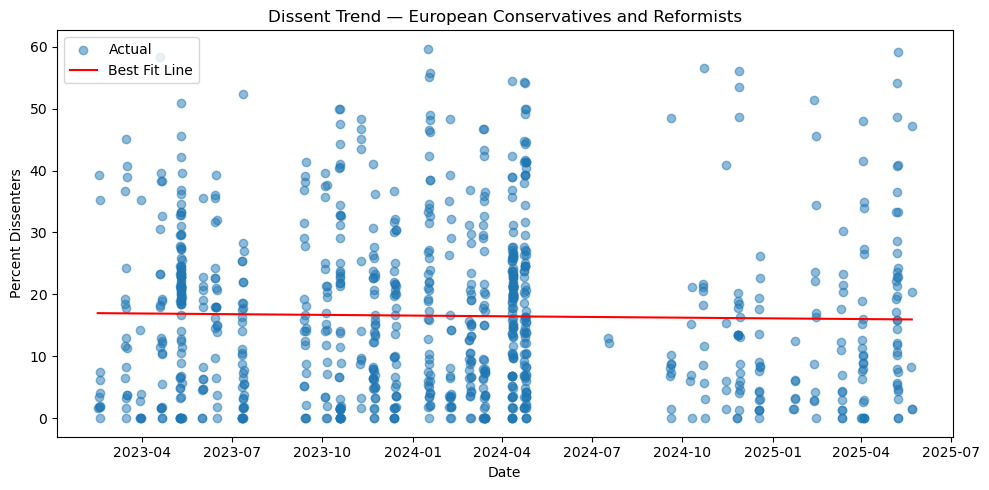

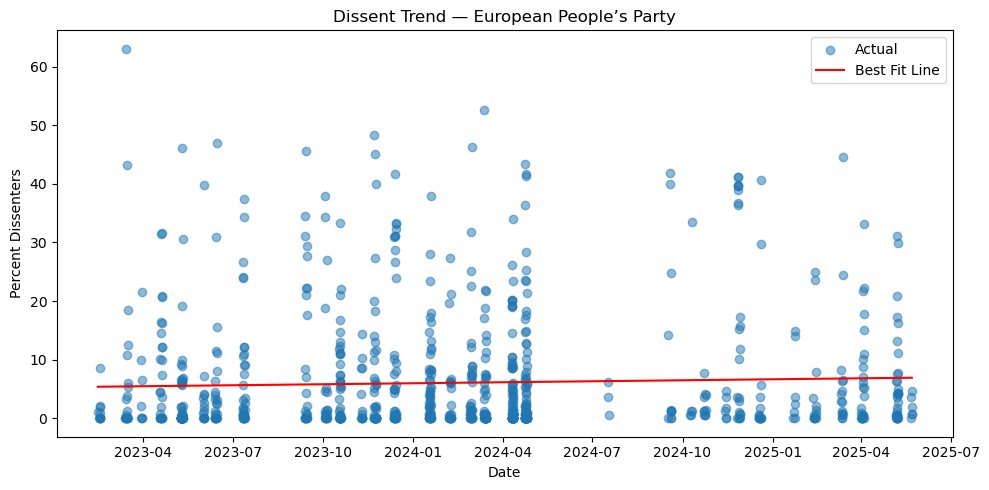

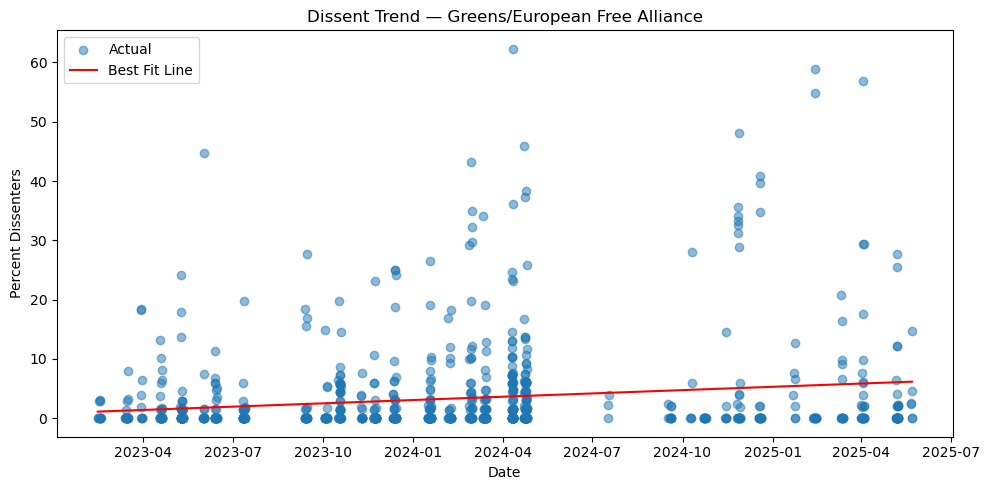

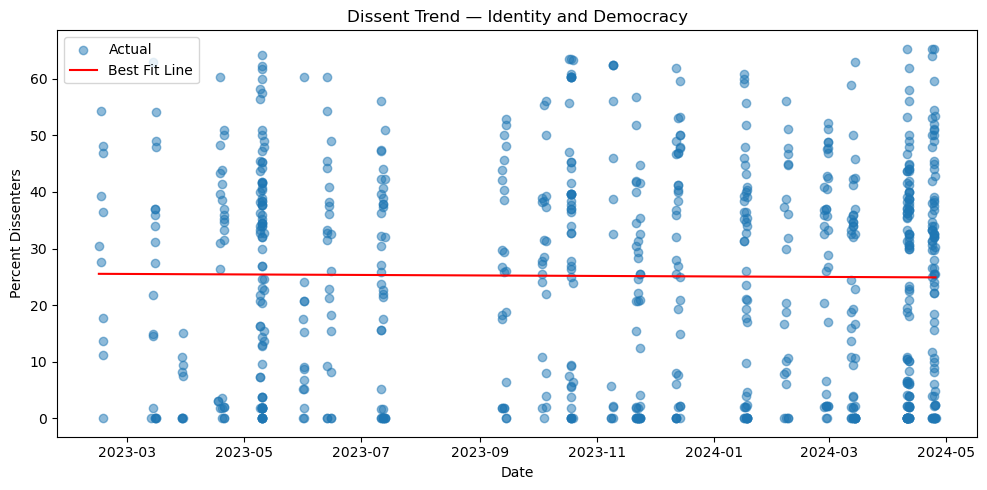

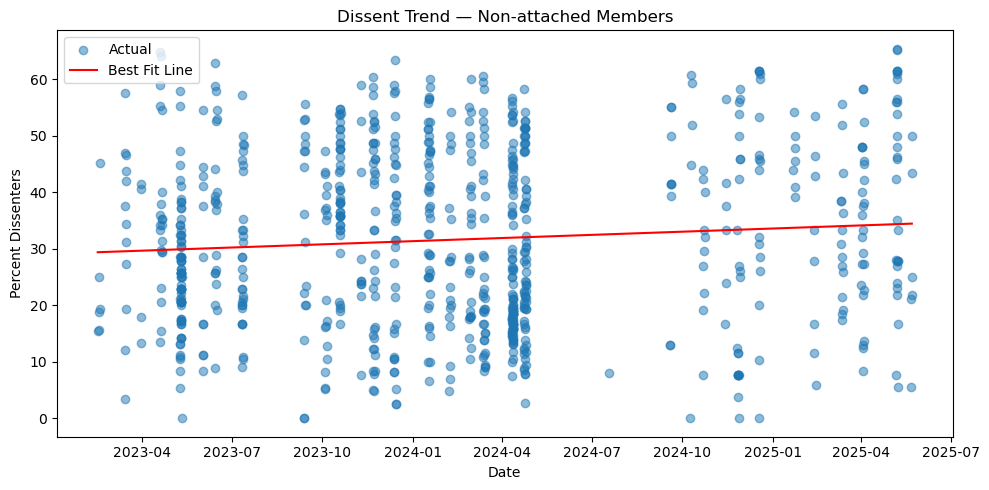

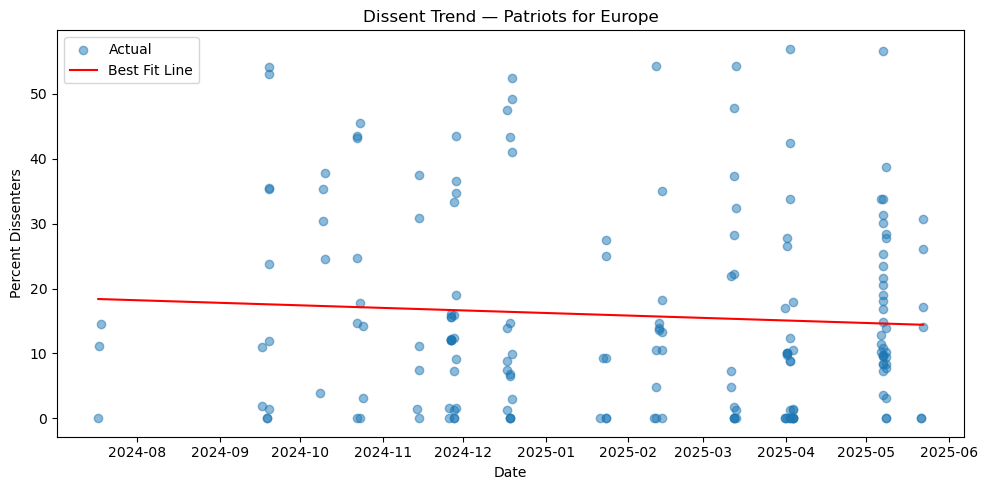

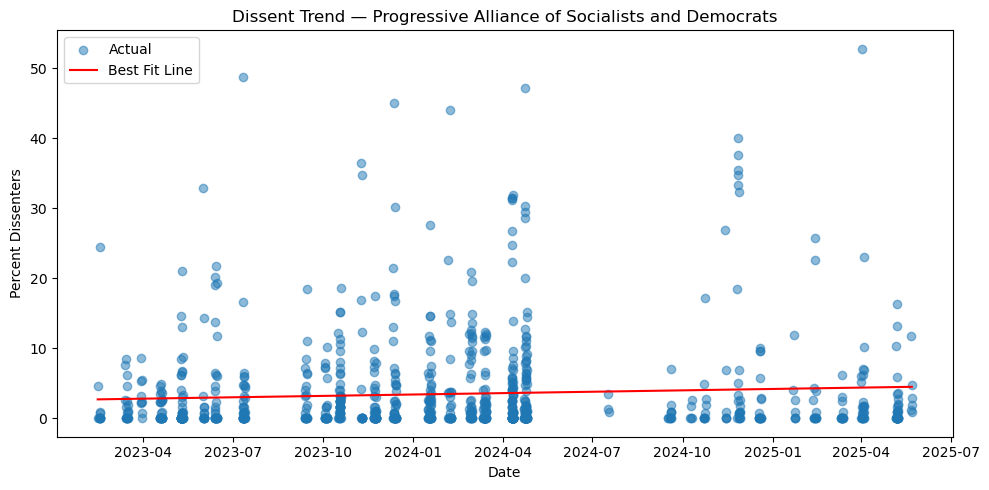

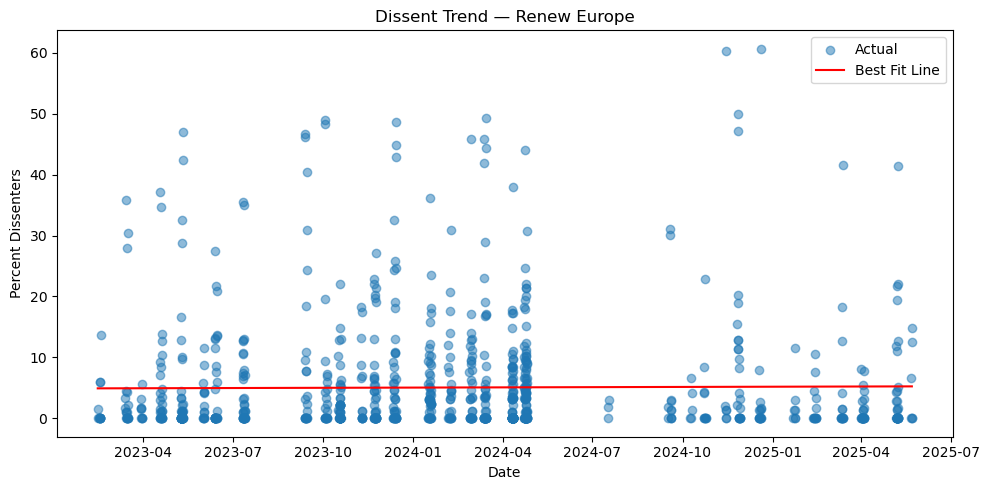

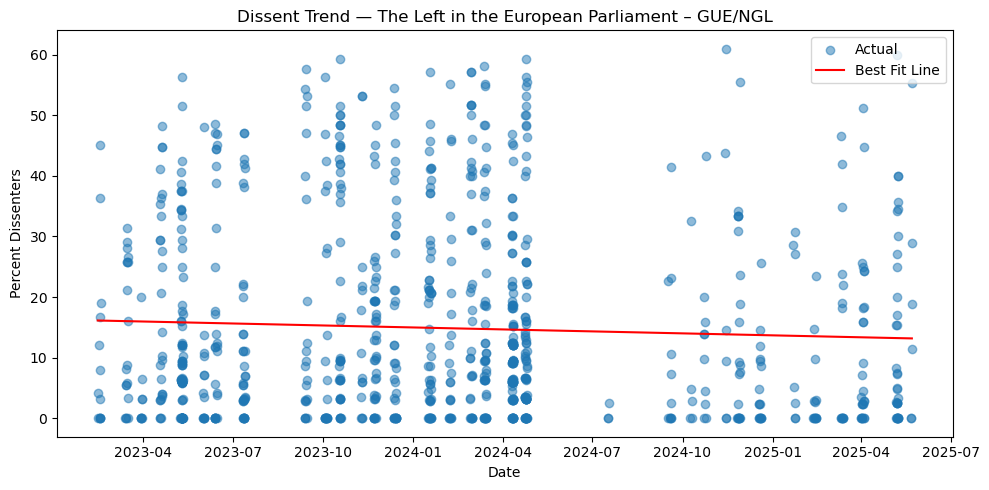

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# sort by date
df = df.sort_values('date')

# plot for each party
for party, group in df.groupby('party'):
    if len(group) < 10:
        continue

    group = group.copy()
    group['date_ordinal'] = group['date'].map(pd.Timestamp.toordinal)
    X = group['date_ordinal'].values.reshape(-1, 1)
    y = group['percent_dissenters'].values

    # fit regression model
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # plot line of best fit
    plt.figure(figsize=(10, 5))
    plt.scatter(group['date'], y, alpha=0.5, label='Actual')
    plt.plot(group['date'], y_pred, color='red', label='Best Fit Line')

    plt.xlabel('Date')
    plt.ylabel('Percent Dissenters')
    plt.title(f'Dissent Trend — {party}')
    plt.legend()
    plt.tight_layout()
    plt.show()